In [9]:
import csv
import json
import os
from PIL import Image

import pprint
import re
import copy

import skimage.draw

import visualize
import utils as my_utils

import matplotlib.pyplot as plt
import cv2

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

Note: you may need to restart the kernel to use updated packages.


# Data structures

In [10]:
# global context variables
segmentation_path = './data/segmentation_masks' # a folder of annotation files
img_path = './data/images' # a folder of image files

In [11]:
class img_meta:
    # img_name: image file name
    # annotations: the annotation list
    
    def __str__(self):
        return 'img_name: ' + self.img_name +  ', mask_name: \n' + self.mask_name
    def __repr__(self):
        return 'img_name: ' + self.img_name +  ', mask_name: \n' + self.mask_name
    
    def process(self, img_name, segmentation_path):
        
        self.img_name = img_name
        
        img_tokens = img_name.strip('.png')
        img_tokens = img_tokens.split('_')
        
        img_key = img_tokens[0]
        img_name_key = img_tokens[1]
        
#         print(f"Image name_key: {img_name_key}")
#         print(f"Image key: {img_key}")
        
        # Check all segmentation masks
        mask_files = os.listdir(segmentation_path)
        
        for file in mask_files:
            
            file_copy = copy.deepcopy(file)
            file_copy = re.sub(r"\.[0-9]", "", file_copy)
            
            mask_tokens = file_copy.split('_')
            mask_name_key = mask_tokens[0]
            
            for token in mask_tokens:
                if len(token)<=2:
                    mask_key = token
                    break
            
#             print("Mask Key: ", mask_key)
            if img_key == mask_key:
                self.mask_name = file
                break


    
    #This function uses opencv rather than PIL to load image.

    def load_image(self):
        
        img_file_path = os.path.join(img_path, self.img_name)
        
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = cv2.imread(img_file_path)
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]

        return image
    
    def load_mask(self):
        mask_file_path = os.path.join(segmentation_path, self.mask_name)
        
        # Load mask
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)
        # Normalize mask between (0-1)
        mask = np.where(mask>0, 1, 0)

        return mask

# Parse all image files

In [12]:
img_metas = []

for file in os.listdir(img_path):
    if file.endswith('.png'):
        print('Processing', file, '...')
        img_meta_obj = img_meta()
        img_meta_obj.process(file, segmentation_path)
        img_metas.append(img_meta_obj)
    else:
        print('[WARNING] Non-image file detected:', file)

Processing 10_bachamollaharshavardhanreddy.png ...
Processing 10_kanugovimahidhar.png ...
Processing 10_rabbyshahariar.png ...
Processing 11_bachamollaharshavardhanreddy.png ...
Processing 11_karnasaimanishreddy.png ...
Processing 11_rabbyshahariar.png ...
Processing 11_rajakvarunraju.png ...
Processing 12_keshidianudeep.png ...
Processing 12_rajakvarunraju.png ...
Processing 13_kollasaividwan.png ...
Processing 14_kongarachanikya.png ...
Processing 15_bonuvarshinireddy.png ...
Processing 15_rayallavineethabhavya.png ...
Processing 16_bonuvarshinireddy.png ...
Processing 16_rayallavineethabhavya.png ...
Processing 17_lakkireddybrunda.png ...
Processing 17_runjalasunithaglory.png ...
Processing 18_bungmahesh.png ...
Processing 18_runjalasunithaglory.png ...
Processing 18_sahapratim.png ...
Processing 19_bungmahesh.png ...
Processing 19_sahapratim.png ...
Processing 1_adhikarisaugat.png ...
Processing 1_ahsanmuhammad.png ...
Processing 1_pandirinikhilkumar.png ...
Processing 20_chaudhary

### Check one object

In [13]:
print(len(img_metas))

img_meta_obj = img_metas[1]
print(img_meta_obj)

150
img_name: 10_kanugovimahidhar.png, mask_name: 
bachamollaharshavardhanreddy_6011154_67421512_10_segment_mask.png


### Load an image

(387, 368, 3)


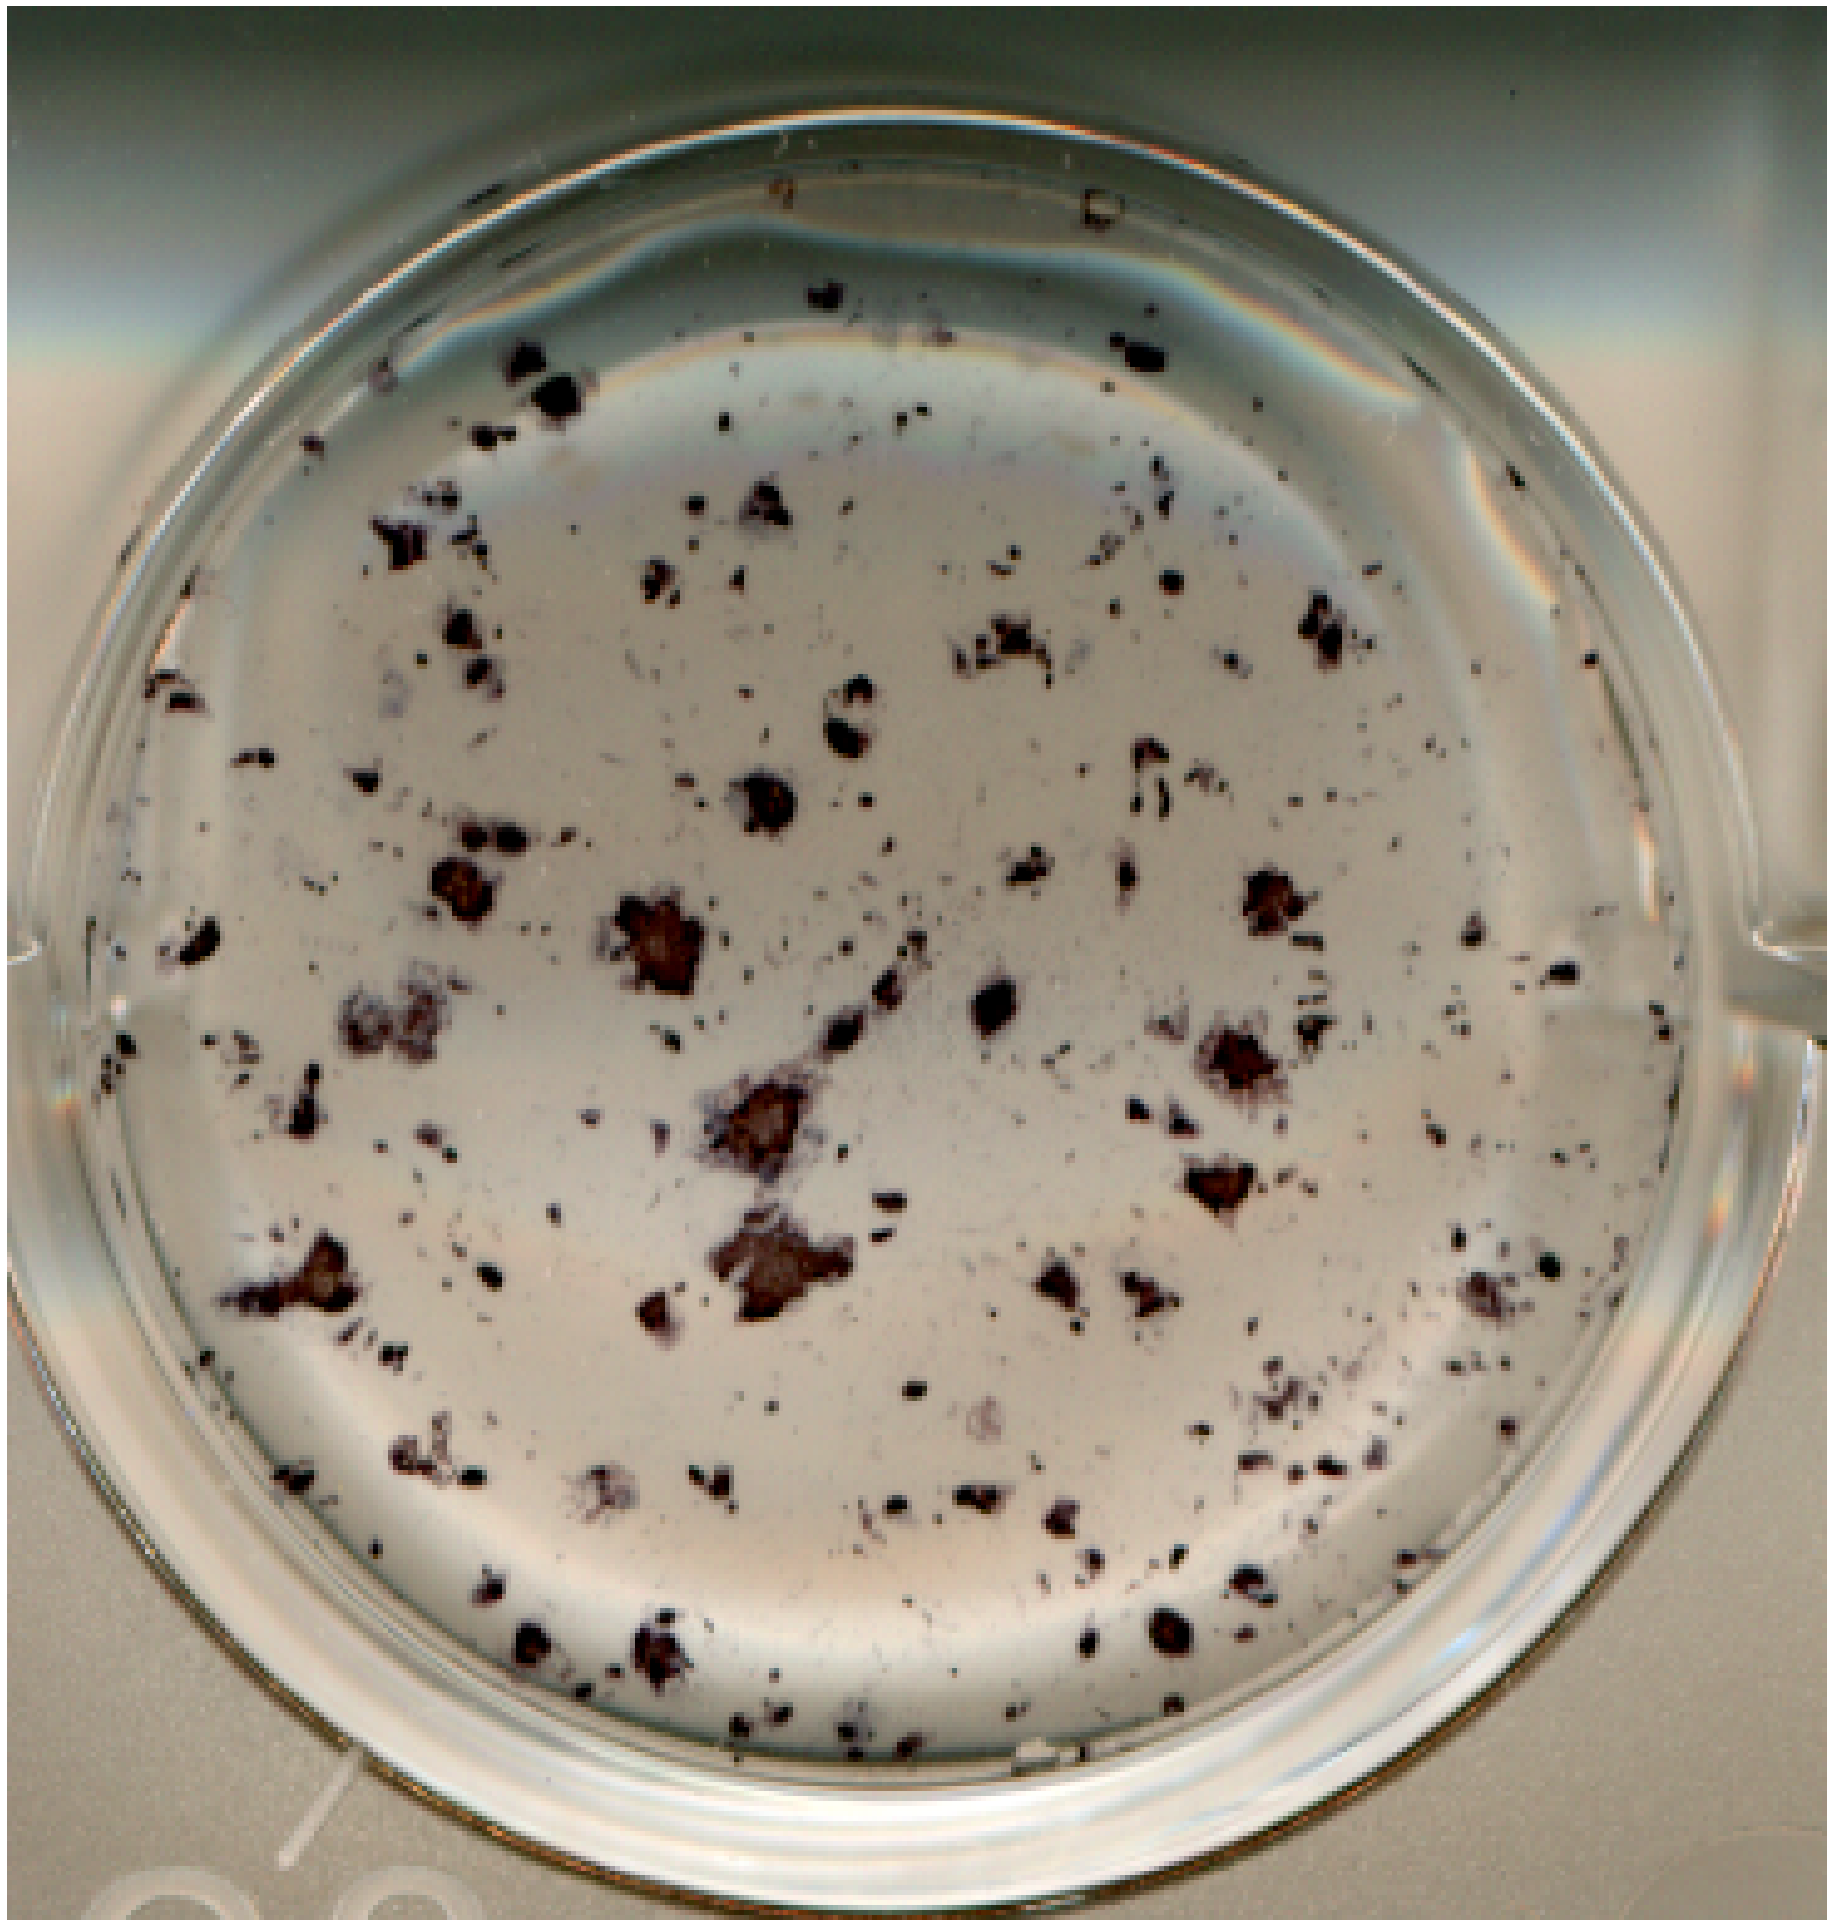

In [14]:
img_obj = img_meta_obj.load_image()
print(img_obj.shape)
visualize.display_images([img_obj])

# Visualize image with mask

In [15]:
# Visualize a random file

colors = visualize.random_colors(5)
color = colors[0]

#sample_idx = np.random.choice(len(img_metas))
sample_idx = 1
print("Sample Index: ", sample_idx)

#Image Meta Data
img_meta_obj = img_metas[sample_idx]

img_file = img_meta_obj.load_image()
print("Image shape: ", img_file.shape)

mask = img_meta_obj.load_mask()

print("Mask shape: ", mask.shape)

Sample Index:  1
Image shape:  (387, 368, 3)
Mask shape:  (387, 368)


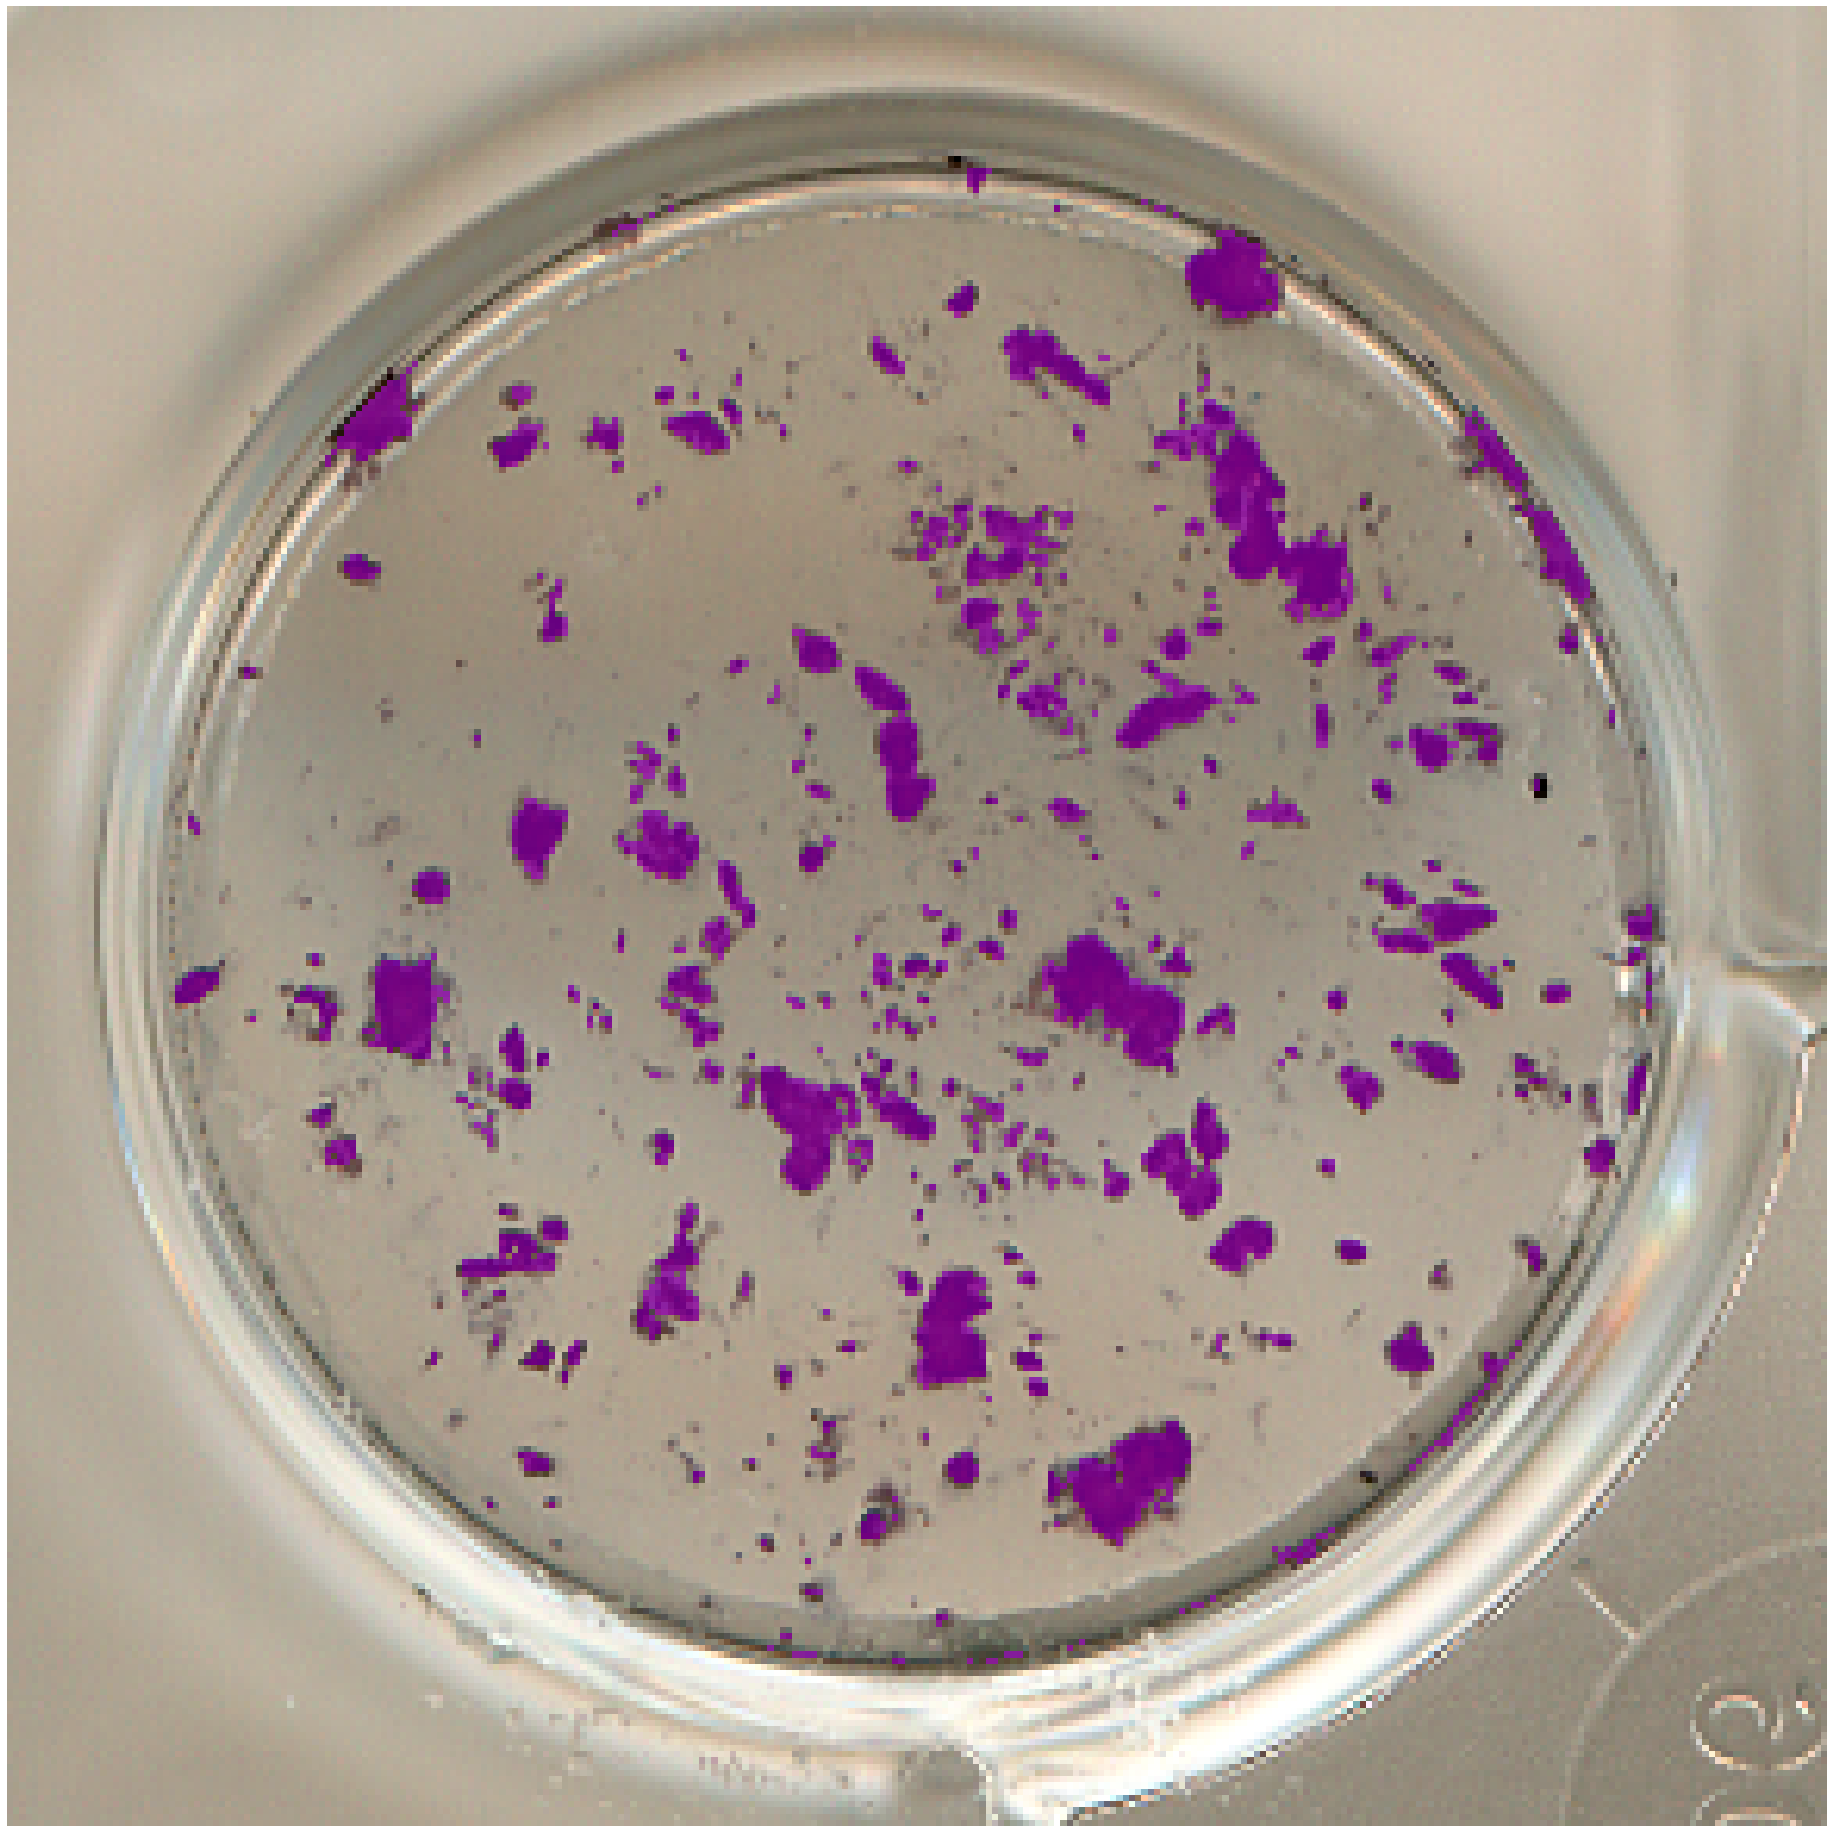

In [8]:
masked_image = visualize.apply_mask(img_file, mask, color)
visualize.display_images([masked_image])

# U-Net demo

### Data processing

In [16]:
# Image size that we are going to use
IMG_SIZE = 256
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Foreground and backgroung
N_CLASSES = 2

In [17]:
#Loads the data and creates a tuple of images
#masks to be later made into Tensorflow data object

def dataLoader():
    img_list = []
    mask_list = []
    
    
    for i in range(len(img_metas)):
        
        img_meta_obj = img_metas[i]
        
        img_file = img_meta_obj.load_image()
        #print("Image shape: ", img_file.shape)
        
        #Convert mask to the shape of an image (3D) with channel=1
        mask = img_meta_obj.load_mask()
        mask = np.expand_dims(mask, axis =-1)

        
        #Rezize mask and image to common size
        # Resize Image to 256x256
        img_file, _, scale, padding,_ = my_utils.resize_image(img_file, max_dim = IMG_SIZE, mode="square")
        #print("Image shape: ", img_file.shape)
        # Resize Mask to 256x256
        mask = my_utils.resize_mask(mask, scale, padding)
        #Fix Overlap bug
        mask = np.where(mask > 0, 1, 0)
        mask = mask.astype(np.float32)
        #print(np.amax(mask))
        #print("Mask shape: ", mask.shape)
        
        #Normalize Image
        img_file = img_file.astype(np.float32)
        img_file = img_file/255.0
        #print("Image shape: ", img_file.shape)
        

        img_list.append(img_file)
        mask_list.append(mask)

    return (img_list, mask_list)

### Create Tensorflow Data Loader

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(dataLoader())

#### Train/Validation Split

In [19]:
train_size = int(0.9 * len(img_metas))
val_size = int(0.1 * len(img_metas))

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Training

## The following training code and model code was adapted from
### https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/

#### Data Tuning Parameters

In [20]:
BATCH_SIZE = 5
BUFFER_SIZE = 1000
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [21]:
dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
#dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

# how shuffle works: https://stackoverflow.com/a/53517848

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [22]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

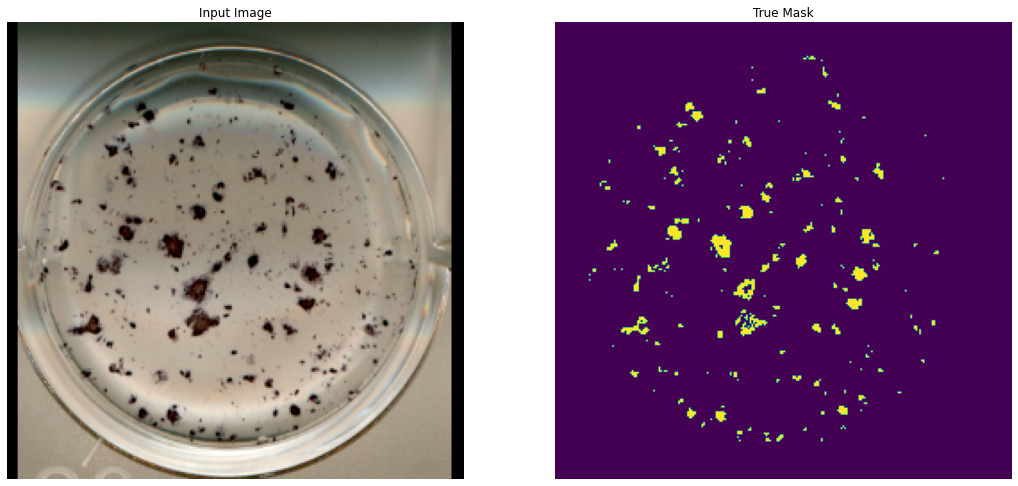

In [23]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    

display_sample([sample_image[1], sample_mask[1]])

In [24]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# If you want to know more about why we are using `he_normal`: 
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excelent fastai course: 
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Decoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

### Model Saver Class

In [25]:
#This class will automatically save TF models
#at Epoch which are multiples of the SAVE_MULTIPLE parameter.
SAVE_MULTIPLE = 5

class ModelSaver(tf.keras.callbacks.Callback): 
    
    def on_epoch_end(self, epoch, logs={}):
        if (epoch)%SAVE_MULTIPLE == 0:  # Save when epochs are multiples of SAVE_MULTIPLE.
            self.model.save(f"./saved_models/model_{epoch}.h5")

## Custom Loss Function

#### In this case dice loss is used according to the implementation in:
https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html

In [26]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

### Create and Compile Model

In [27]:
model = tf.keras.Model(inputs = inputs, outputs = output)

In [28]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = dice_loss,
              metrics=['accuracy'])

#### Create moodel saver instance

In [29]:
# create and use callback:
saver = ModelSaver()

#### Training Hyperparameters

In [30]:
EPOCHS = 50

STEPS_PER_EPOCH = train_size // BATCH_SIZE
VALIDATION_STEPS = val_size // BATCH_SIZE

### Start Training

In [31]:

model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          callbacks=[saver],
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

Epoch 1/50
27/27 [==============================] - 197s 7s/step - loss: 0.9470 - accuracy: 0.9721 - val_loss: 0.9613 - val_accuracy: 0.9801
Epoch 2/50
27/27 [==============================] - 203s 8s/step - loss: 0.9469 - accuracy: 0.9721 - val_loss: 0.9613 - val_accuracy: 0.9801
Epoch 3/50
27/27 [==============================] - 207s 8s/step - loss: 0.9468 - accuracy: 0.9721 - val_loss: 0.9613 - val_accuracy: 0.9801
Epoch 4/50
27/27 [==============================] - 208s 8s/step - loss: 0.9468 - accuracy: 0.9721 - val_loss: 0.9613 - val_accuracy: 0.9801
Epoch 5/50
27/27 [==============================] - 209s 8s/step - loss: 0.9468 - accuracy: 0.9721 - val_loss: 0.9613 - val_accuracy: 0.9801
Epoch 6/50
27/27 [==============================] - 207s 8s/step - loss: 0.9468 - accuracy: 0.9721 - val_loss: 0.9612 - val_accuracy: 0.9801
Epoch 7/50
27/27 [==============================] - 312s 12s/step - loss: 0.9468 - accuracy: 0.9721 - val_loss: 0.9612 - val_accuracy: 0.9801
Epoch 8/50
2

#### Manually Save Model

In [32]:
## Save the model at the latest EPOCH or as desired
model.save(f"./saved_models/model_{EPOCHS}.h5")

#### Load 

In [33]:
MODEL_PATH = "./saved_models/model_45.h5" #Change this to the model path you want to load

model.load_weights(MODEL_PATH, by_name=True)

# Process Prediction

In [34]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [35]:
#Pick first batch of Image from Validation set
for image, mask in dataset['val'].take(1):
    sample_image, sample_mask = image, mask

In [36]:
#Pick first Prediction Validation set
sample_idx = 2
pred_mask = model.predict(sample_image)

sample_image = sample_image.numpy()[sample_idx] #Pick first image form a batch of 5
sample_image = (sample_image*255.0).astype(np.uint32)

#Ground Truth Mask
sample_mask = sample_mask.numpy()[sample_idx]
sample_mask = np.squeeze(sample_mask, axis =-1)

#Predicted Mask
pred_mask = pred_mask[sample_idx] #Pick first mask form a batch of 5

In [37]:
print(sample_image.shape)
print(pred_mask.shape)

(256, 256, 3)
(256, 256, 2)


In [38]:
pred_mask = np.argmax(pred_mask, axis =-1)
#pred_mask = np.expand_dims(pred_mask, axis =-1)
print(sample_image.shape)
print(pred_mask.shape)

(256, 256, 3)
(256, 256)


### Visualize Prediction

(0.0, 0.40000000000000036, 1.0)


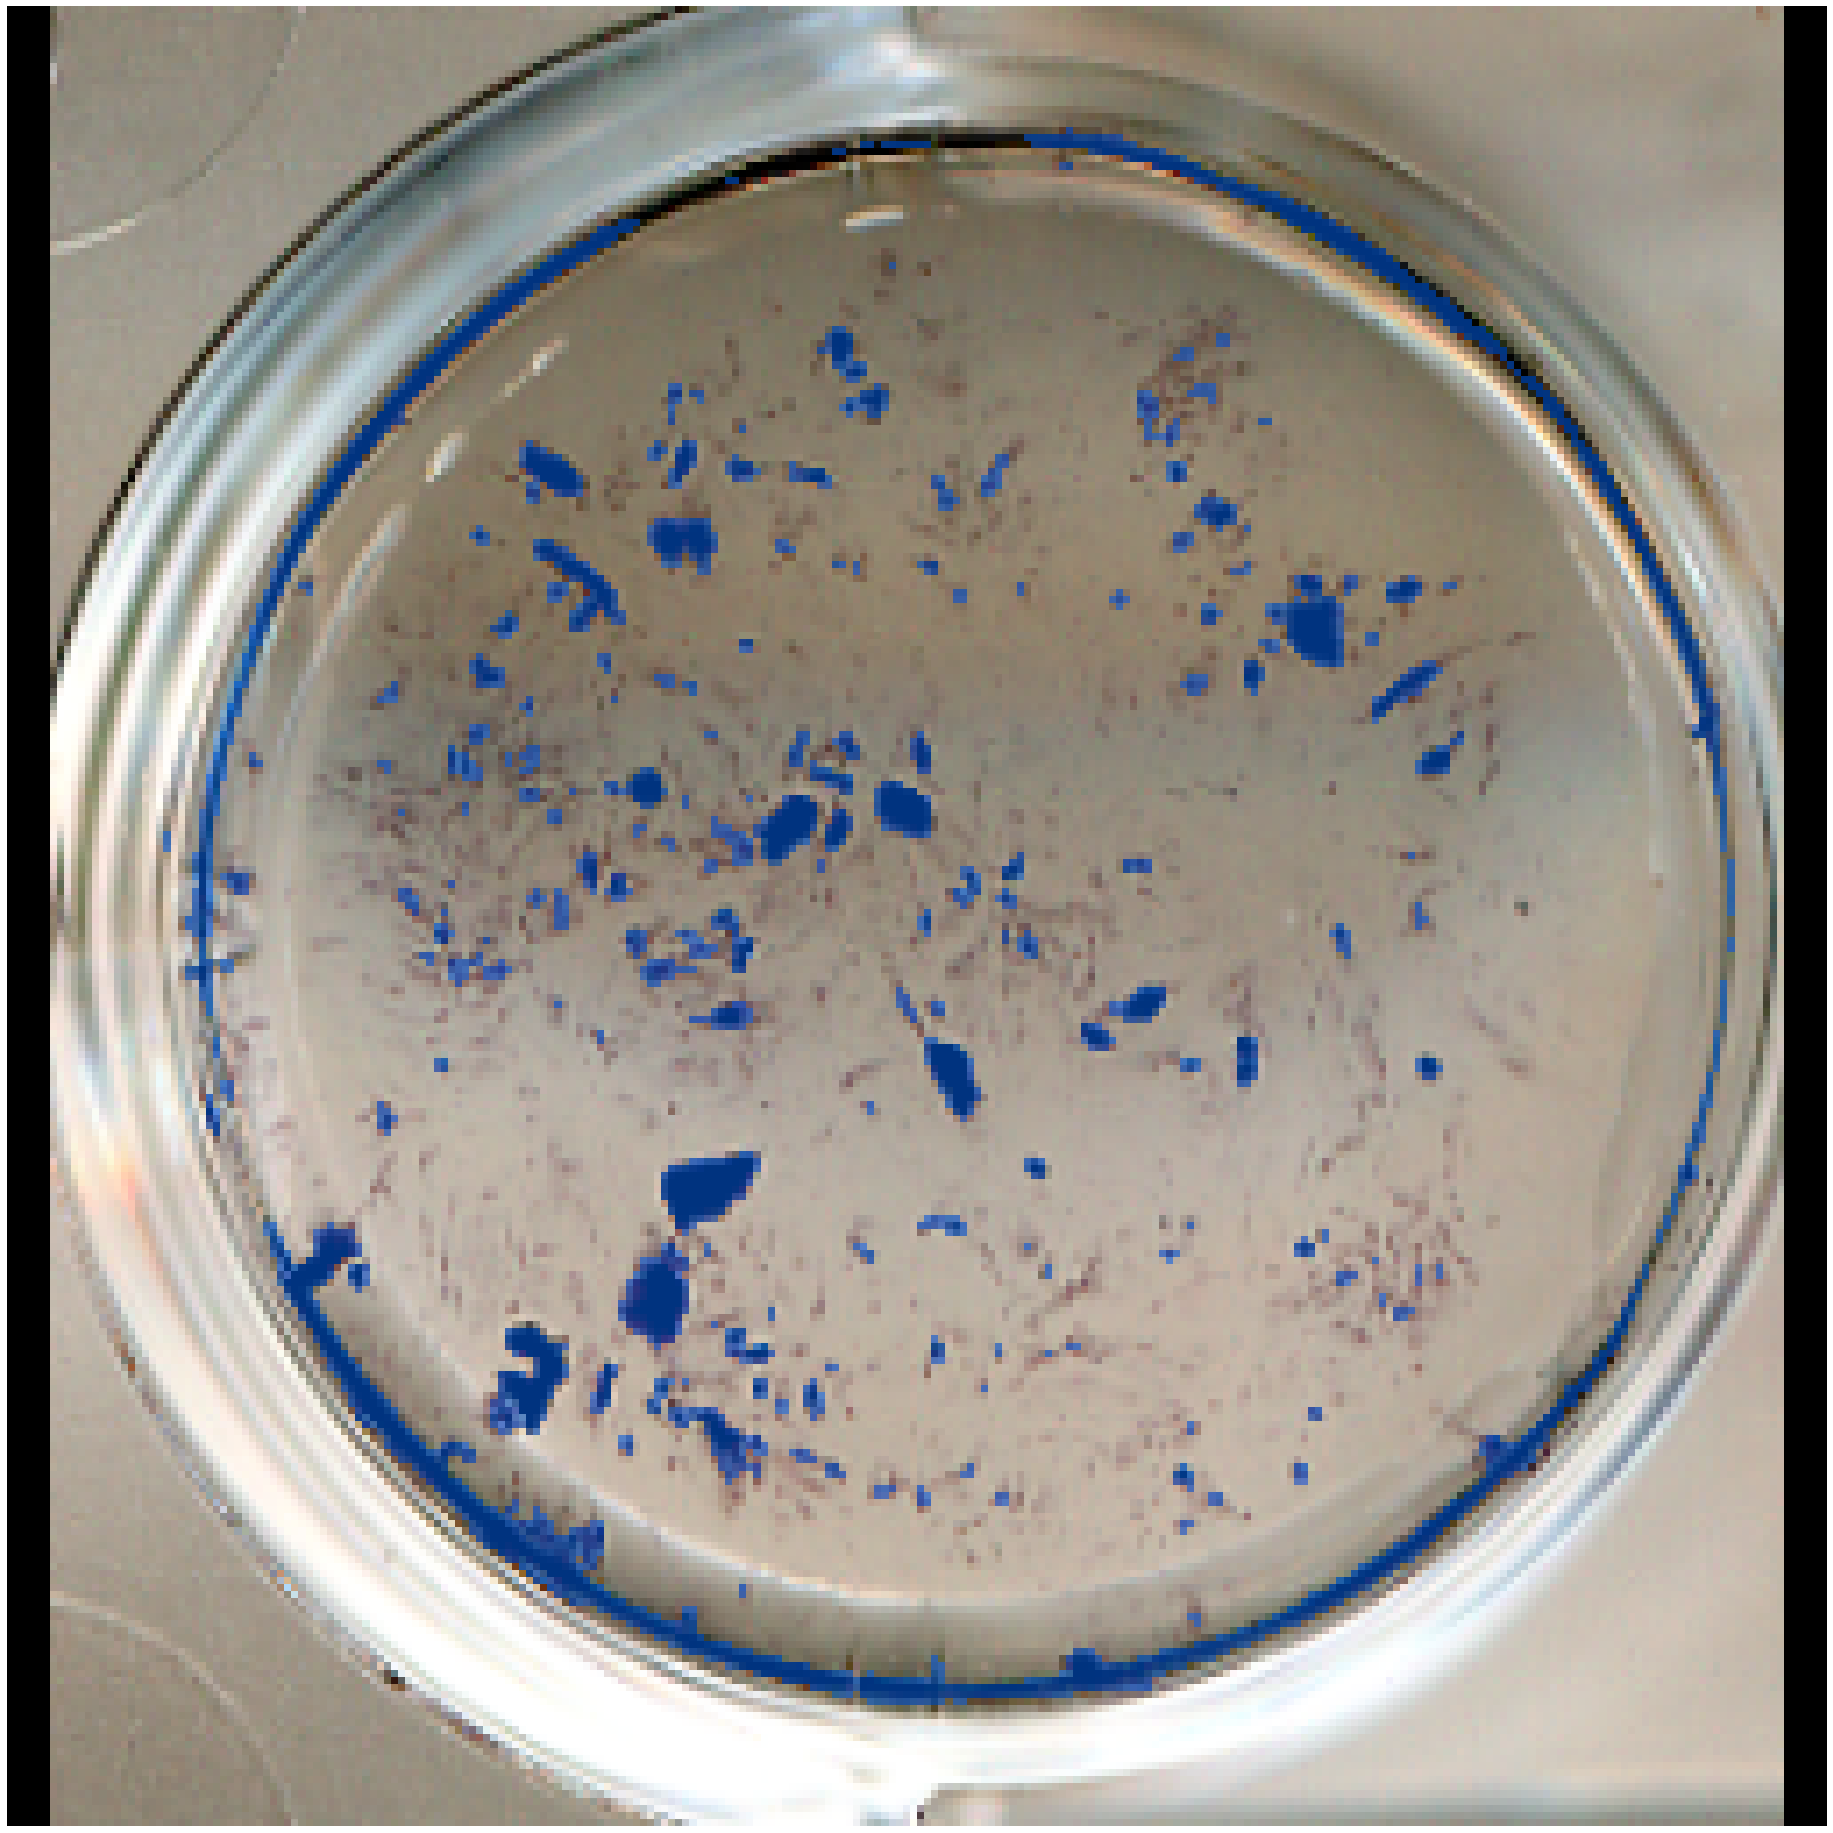

In [39]:
colors = visualize.random_colors(10)
color = colors[0]
print(color)

masked_image = sample_image.astype(np.uint32).copy()
masked_image = visualize.apply_mask(masked_image, pred_mask, color)

visualize.display_images([masked_image])

In [33]:
# Vizualize Ground Truth

(0.7999999999999998, 1.0, 0.0)
(256, 256, 3)
(256, 256)


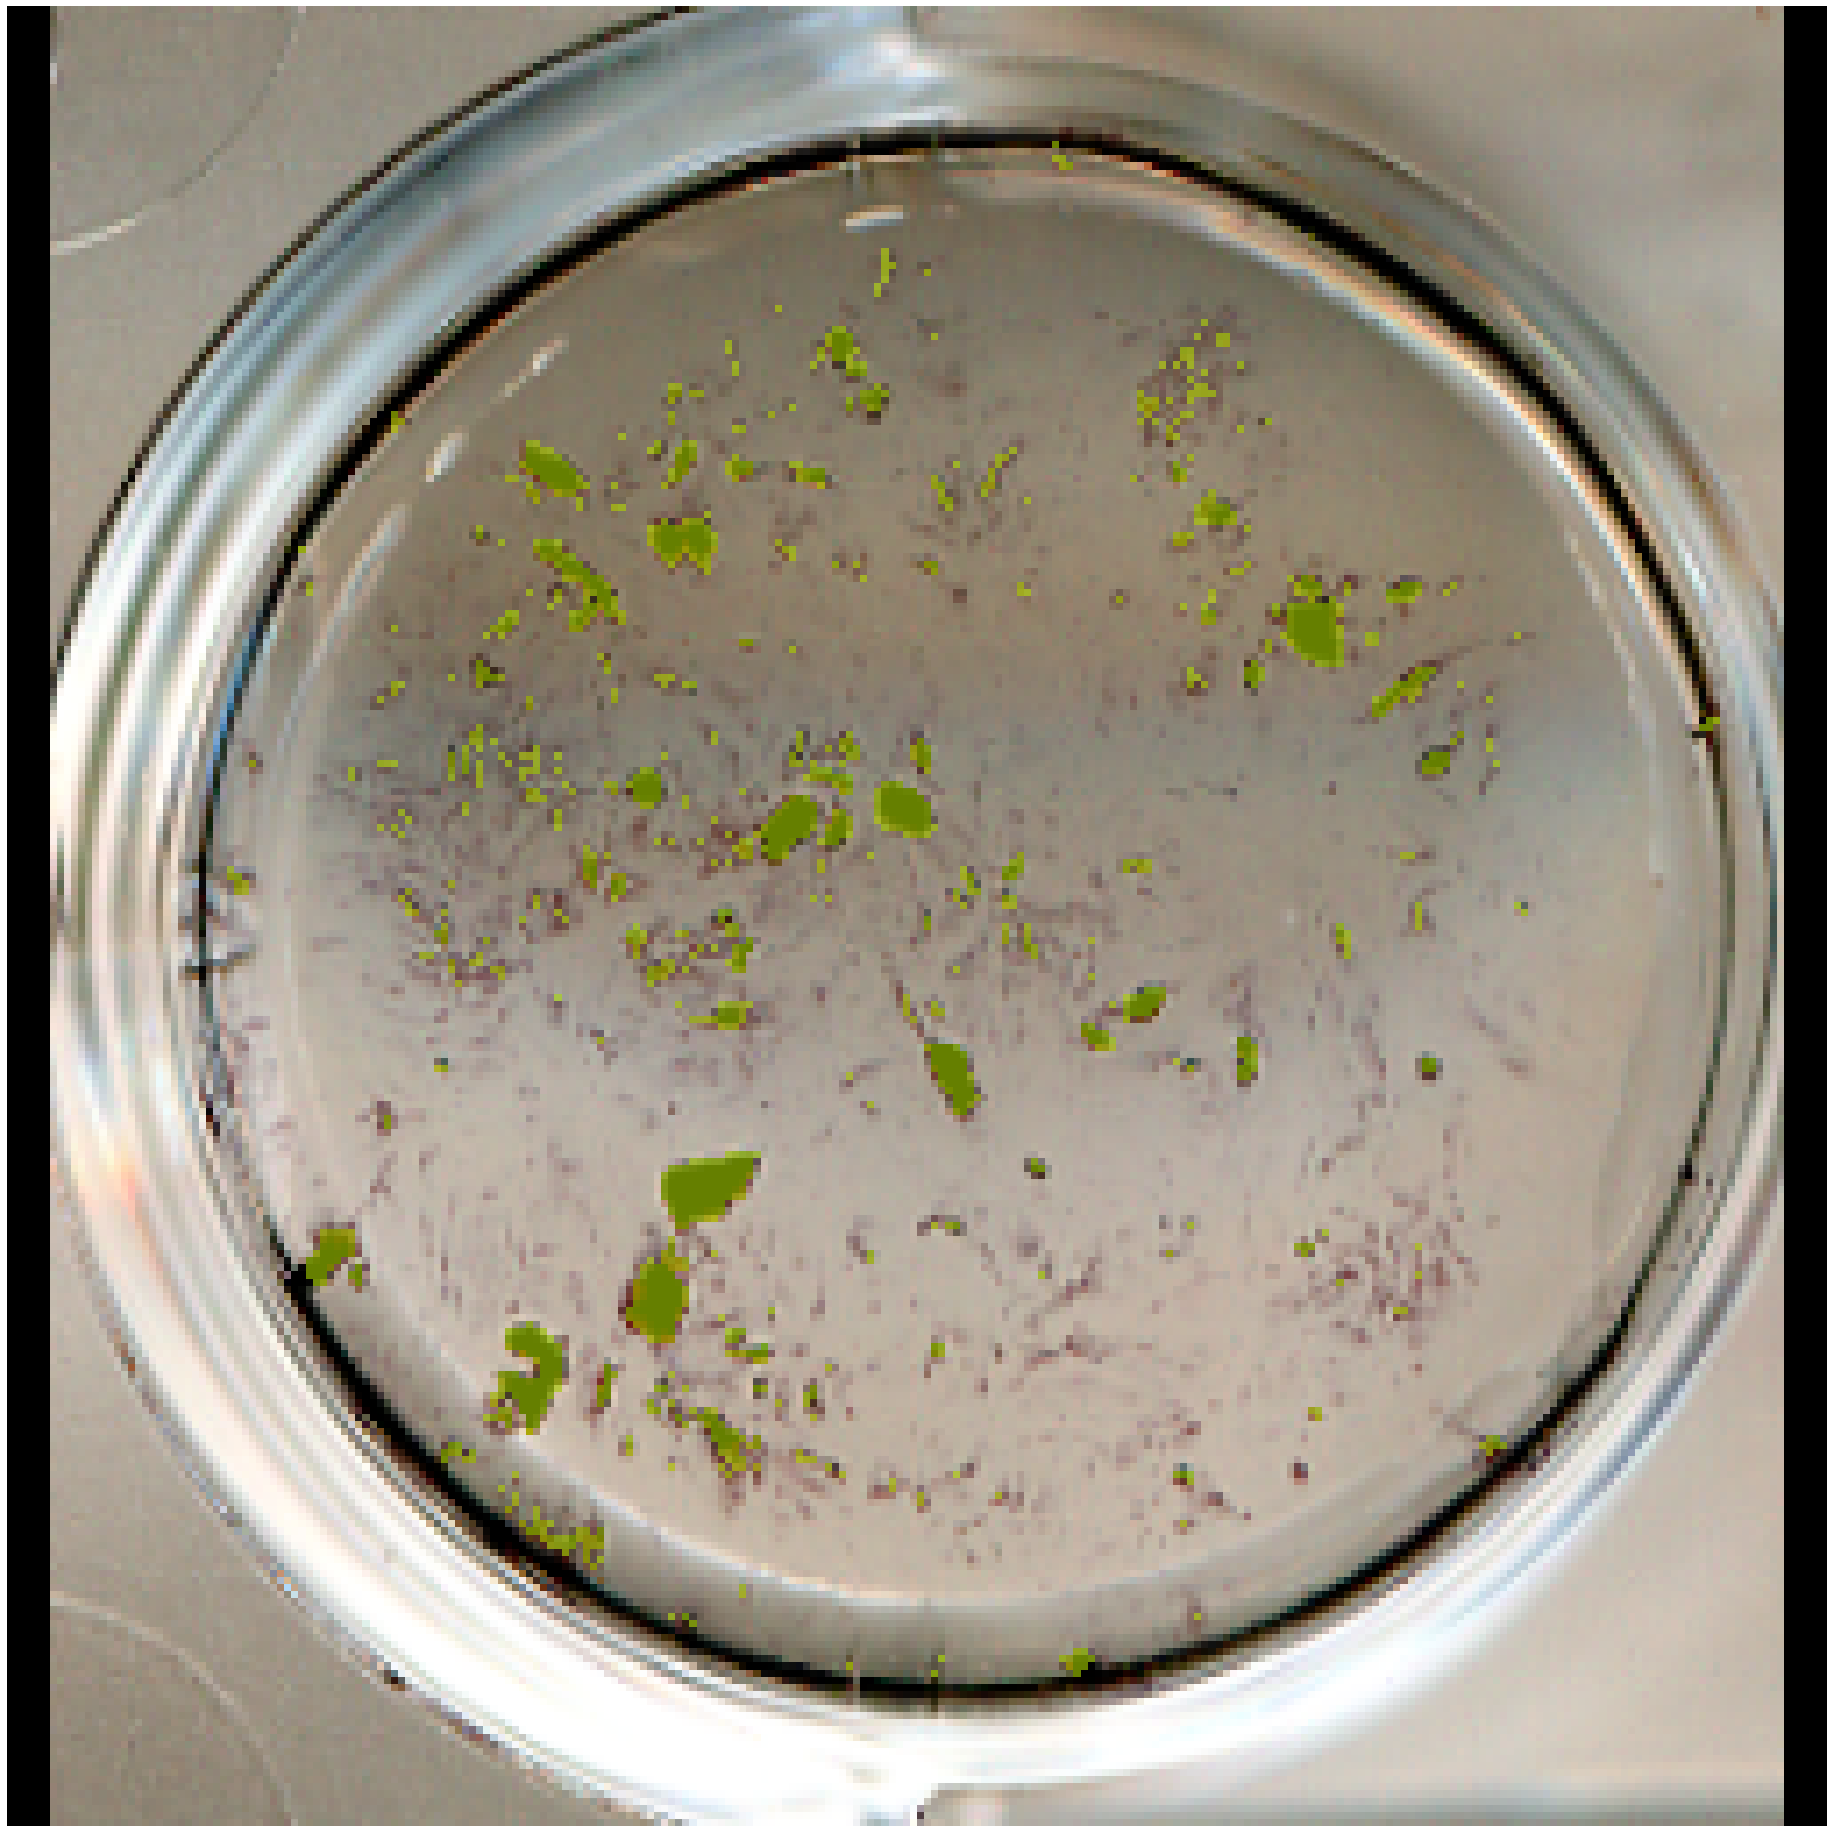

In [40]:
#GT
colors = visualize.random_colors(10)
color = colors[0]
print(color)

masked_image = sample_image.astype(np.uint32).copy()

print(masked_image.shape)
print(sample_mask.shape)

masked_image = visualize.apply_mask(masked_image, sample_mask, color)

visualize.display_images([masked_image])